# Fine‑tuning YAMNet for Human Screaming Detection

In [5]:
# Cell 1: Install dependencies
!pip install -q tensorflow==2.11.* tensorflow_io==0.28.* tensorflow-hub kagglehub
!pip install -q librosa soundfile


In [2]:
!nvidia-smi

Sun Apr 20 10:21:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 80GB HBM3          Off |   00000000:05:00.0 Off |                    0 |
| N/A   28C    P0            119W /  700W |       1MiB /  81559MiB |      4%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
# Cell 2: Imports
import os, glob
import pandas as pd
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
import kagglehub


2025-04-20 14:27:51.005378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-20 14:27:51.971158: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-20 14:27:52.262002: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2025-04-20 14:27:52.262021: I tensorflo

In [4]:
# Cell 3: Download the screaming dataset
path = kagglehub.dataset_download("whats2000/human-screaming-detection-dataset")
print("Dataset path:", path)

# List out the folders in the dataset
folders = glob.glob(os.path.join(path, "*"))
print("Folders in the dataset:", folders)


Dataset path: /home/user/.cache/kagglehub/datasets/whats2000/human-screaming-detection-dataset/versions/2
Folders in the dataset: ['/home/user/.cache/kagglehub/datasets/whats2000/human-screaming-detection-dataset/versions/2/NotScreaming', '/home/user/.cache/kagglehub/datasets/whats2000/human-screaming-detection-dataset/versions/2/Screaming']


In [5]:
# Cell 4: Build a DataFrame of WAV paths + labels
screaming_paths = glob.glob(os.path.join(path, 'Screaming', '*.wav'))
not_screaming_paths = glob.glob(os.path.join(path, 'NotScreaming', '*.wav'))

# Create DataFrame with explicit labels based on folders
df = pd.DataFrame([
    {'filename': path, 'label': 1} for path in screaming_paths
] + [
    {'filename': path, 'label': 0} for path in not_screaming_paths
])

# Display dataset statistics
print(f"Total files: {len(df)}")
print(f"Screaming files: {len(screaming_paths)}")
print(f"Non-screaming files: {len(not_screaming_paths)}")
print("\nSample of the DataFrame:")
df.head()


Total files: 3493
Screaming files: 862
Non-screaming files: 2631

Sample of the DataFrame:


,filename,label
0,/home/user/.cache/kagglehub/datasets/whats2000...,1
1,/home/user/.cache/kagglehub/datasets/whats2000...,1
2,/home/user/.cache/kagglehub/datasets/whats2000...,1
3,/home/user/.cache/kagglehub/datasets/whats2000...,1
4,/home/user/.cache/kagglehub/datasets/whats2000...,1


In [6]:
# Cell 5: Train/test split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)
print(f"Train: {len(train_df)} files,  Test: {len(test_df)} files")


Train: 2235 files,  Test: 699 files


In [7]:
# Cell 6 (librosa loader): load + resample via librosa/soundfile
import librosa
import tensorflow as tf

def load_wav_16k_mono(filename):
    # `filename` arrives as a tf.Tensor inside py_function; grab its string value
    path = filename.numpy().decode('utf-8')
    # load+convert to 16 kHz mono
    wav, _ = librosa.load(path, sr=16000, mono=True)
    # ensure float32
    return wav.astype('float32')

yamnet_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_handle)


2025-04-20 14:28:24.931668: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-20 14:28:24.932896: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2025-04-20 14:28:24.932974: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2025-04-20 14:28:24.933018: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared

In [8]:
# Cell 7: build tf.data pipeline (librosa + YAMNet)
def preprocess_row(filename, label):
    # load_wav_16k_mono returns a NumPy array of float32
    wav = load_wav_16k_mono(filename)
    wav = tf.convert_to_tensor(wav, dtype=tf.float32)      # to TF tensor
    _, embeddings, _ = yamnet_model(wav)                    # frame-level embeddings
    emb = tf.reduce_mean(embeddings, axis=0)                # clip-level
    return emb, label

def make_dataset(df, batch_size=32, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(
        (df['filename'].values, df['label'].values)
    )
    if shuffle:
        ds = ds.shuffle(len(df))
    ds = ds.map(
        lambda f, l: tf.py_function(
            func=preprocess_row,
            inp=[f, l],
            Tout=[tf.float32, tf.int64]     # embeddings + label dtype
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    # now fix shapes & cast label to int32
    def fix(e, l):
        e.set_shape([1024])
        l = tf.cast(l, tf.int32)
        l.set_shape([])
        return e, l

    return ds.map(fix, num_parallel_calls=tf.data.AUTOTUNE) \
             .batch(batch_size) \
             .prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(train_df, shuffle=True)
val_ds   = make_dataset(val_df)
test_ds  = make_dataset(test_df)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [9]:
# Cell 8 (unchanged except name clarity): Define and compile your classifier
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(1024,), name='yamnet_embedding'),
    layers.Dense(256, activation='swish'),
    layers.Dense(62, activation='swish'),
    layers.Dense(1, activation='sigmoid')
], name='scream_detector')

model.compile(    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "scream_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 62)                15934     
                                                                 
 dense_2 (Dense)             (None, 1)                 63        
                                                                 
Total params: 278,397
Trainable params: 278,397
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Cell 9: Train
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[
      tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
      )
    ]
)


Epoch 1/50
70/70 [==============================] - 67s 918ms/step - loss: 0.3020 - accuracy: 0.8761 - val_loss: 0.2725 - val_accuracy: 0.8766
Epoch 2/50
70/70 [==============================] - 46s 664ms/step - loss: 0.2338 - accuracy: 0.9002 - val_loss: 0.2198 - val_accuracy: 0.9267
Epoch 3/50
70/70 [==============================] - 46s 665ms/step - loss: 0.2076 - accuracy: 0.9159 - val_loss: 0.2709 - val_accuracy: 0.9034
Epoch 4/50
70/70 [==============================] - 47s 677ms/step - loss: 0.1756 - accuracy: 0.9266 - val_loss: 0.1864 - val_accuracy: 0.9338
Epoch 5/50
70/70 [==============================] - 46s 665ms/step - loss: 0.1663 - accuracy: 0.9351 - val_loss: 0.2157 - val_accuracy: 0.8980
Epoch 6/50
70/70 [==============================] - 47s 678ms/step - loss: 0.1630 - accuracy: 0.9342 - val_loss: 0.1981 - val_accuracy: 0.9267
Epoch 7/50
70/70 [==============================] - 46s 665ms/step - loss: 0.1464 - accuracy: 0.9414 - val_loss: 0.2809 - val_accuracy: 0.9123

In [11]:
# Cell 10: Evaluate & Save
loss, acc = model.evaluate(test_ds)
print(f"Test loss: {loss:.4f}, accuracy: {acc:.4%}")

model.save('human_scream_detector')


22/22 [==============================] - 13s 600ms/step - loss: 0.1889 - accuracy: 0.9270
Test loss: 0.1889, accuracy: 92.7039%


INFO:tensorflow:Assets written to: human_scream_detector/assets


INFO:tensorflow:Assets written to: human_scream_detector/assets


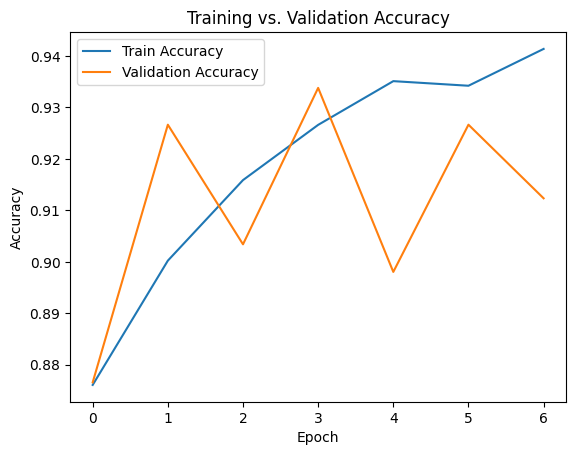

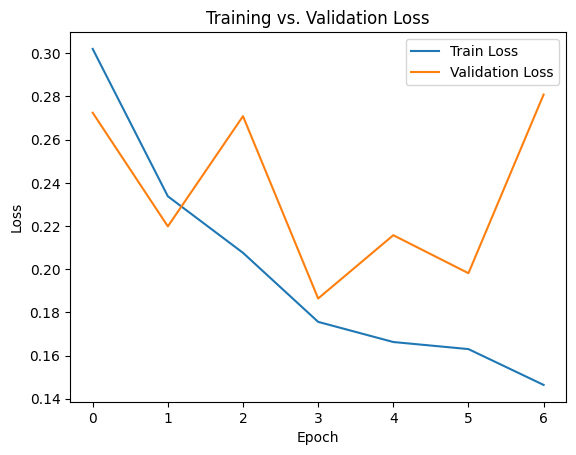

In [12]:
# Cell 11: Plot Training & Validation Curves
import matplotlib.pyplot as plt

# Accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.show()

# Loss
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()


In [13]:
# Cell 12 (revised): Compute Classification Metrics & Confusion Matrix
import numpy as np
import pandas as pd
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve
)

# Gather true labels, predicted labels, and predicted probabilities
y_true = []
y_prob = []
for x_batch, y_batch in test_ds:
    probs = model.predict(x_batch).ravel()
    y_true.extend(y_batch.numpy())
    y_prob.extend(probs)

y_true = np.array(y_true)
y_pred = (np.array(y_prob) >= 0.5).astype(int)

# Use labels=[0,1] so both classes appear even if one is missing
print("Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    labels=[0, 1],
    target_names=['Non‑Scream','Scream'],
    digits=4
))

# Confusion matrix as a DataFrame for readability
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
cm_df = pd.DataFrame(
    cm,
    index=['Actual Non‑Scream','Actual Scream'],
    columns=['Predicted Non‑Scream','Predicted Scream']
)
print("\nConfusion Matrix:")
print(cm_df)

# Summary of key scalar metrics
metrics = {
    'Accuracy' : accuracy_score(y_true, y_pred),
    'Precision': precision_score(y_true, y_pred, zero_division=0),
    'Recall'   : recall_score(y_true, y_pred, zero_division=0),
    'F1‑Score' : f1_score(y_true, y_pred, zero_division=0)
}
metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Score'])
print("\nKey Metrics:")
print(metrics_df)


1/1 [==============================] - 0s 43ms/step
Classification Report:
              precision    recall  f1-score   support

  Non‑Scream     0.9375    0.9677    0.9524       527
      Scream     0.8903    0.8023    0.8440       172

    accuracy                         0.9270       699
   macro avg     0.9139    0.8850    0.8982       699
weighted avg     0.9259    0.9270    0.9257       699


Confusion Matrix:
                   Predicted Non‑Scream  Predicted Scream
Actual Non‑Scream                   510                17
Actual Scream                        34               138

Key Metrics:
              Score
Accuracy   0.927039
Precision  0.890323
Recall     0.802326
F1‑Score   0.844037


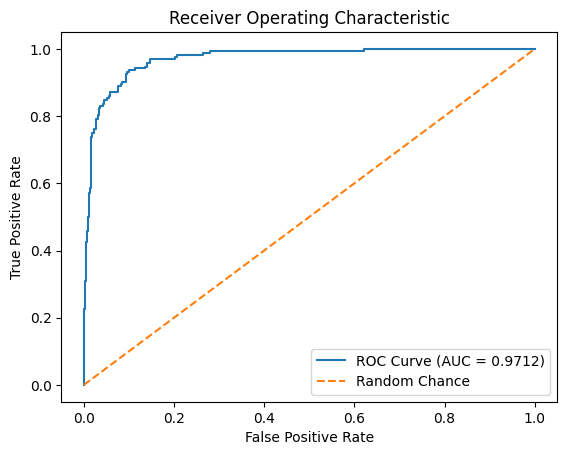

In [14]:
# Cell 13: ROC Curve & AUC
# Compute ROC curve and area under the curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], linestyle='--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()


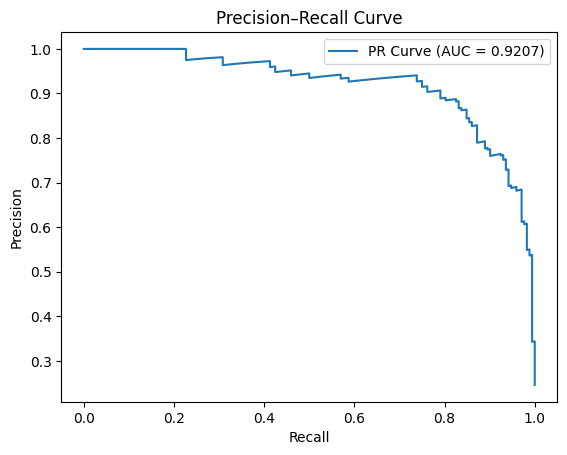

In [15]:
# Cell 14: Precision–Recall Curve & AUC
precision, recall, _ = precision_recall_curve(y_true, y_prob)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.show()


In [16]:
# Cell 15 (revised): Show Top False Positives & Negatives
import pandas as pd
import tensorflow as tf

records = []
for fname, true in zip(test_df['filename'], test_df['label']):
    # 1) Load + preprocess audio
    wav = load_wav_16k_mono(tf.constant(fname))
    # 2) Extract YAMNet embeddings
    _, embeddings, _ = yamnet_model(wav)
    emb = tf.reduce_mean(embeddings, axis=0)
    # 3) Predict scream probability
    prob = model.predict(tf.expand_dims(emb, 0))[0, 0]
    records.append((fname, true, prob))

df_results = pd.DataFrame(records, columns=['filename','true_label','pred_prob'])

# Top 5 false positives (true=0 but pred≥0.5)
fp = df_results[(df_results.true_label == 0) & (df_results.pred_prob >= 0.5)]
print("Top 5 False Positives:")
print(fp.sort_values('pred_prob', ascending=False).head(5))

# Top 5 false negatives (true=1 but pred<0.5)
fn = df_results[(df_results.true_label == 1) & (df_results.pred_prob < 0.5)]
print("\nTop 5 False Negatives:")
print(fn.sort_values('pred_prob').head(5))


1/1 [==============================] - 0s 14ms/step
Top 5 False Positives:
                                              filename  true_label  pred_prob
254  /home/user/.cache/kagglehub/datasets/whats2000...           0   0.969090
109  /home/user/.cache/kagglehub/datasets/whats2000...           0   0.941768
158  /home/user/.cache/kagglehub/datasets/whats2000...           0   0.906785
39   /home/user/.cache/kagglehub/datasets/whats2000...           0   0.886220
613  /home/user/.cache/kagglehub/datasets/whats2000...           0   0.853990

Top 5 False Negatives:
                                              filename  true_label  pred_prob
453  /home/user/.cache/kagglehub/datasets/whats2000...           1   0.000661
658  /home/user/.cache/kagglehub/datasets/whats2000...           1   0.024989
408  /home/user/.cache/kagglehub/datasets/whats2000...           1   0.027353
442  /home/user/.cache/kagglehub/datasets/whats2000...           1   0.058169
271  /home/user/.cache/kagglehub/datasets/w

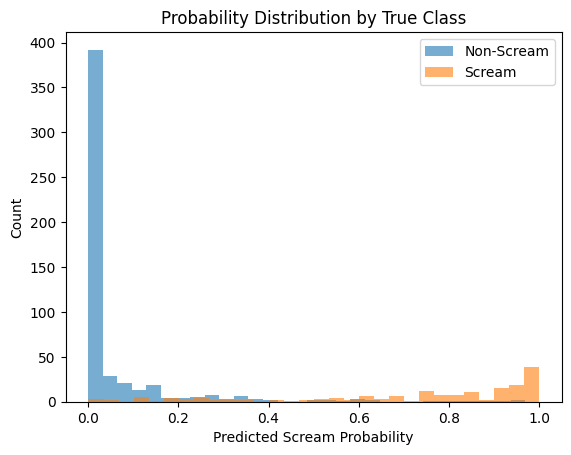

In [17]:
# Cell 16: Probability Distribution by Class
import matplotlib.pyplot as plt
import numpy as np

# collect probs and labels (you already have y_true, y_prob from Cell 12)
probs = np.array(y_prob)
labels = np.array(y_true)

plt.figure()
plt.hist(probs[labels==0], bins=30, alpha=0.6, label='Non‑Scream')
plt.hist(probs[labels==1], bins=30, alpha=0.6, label='Scream')
plt.xlabel('Predicted Scream Probability')
plt.ylabel('Count')
plt.title('Probability Distribution by True Class')
plt.legend()
plt.show()


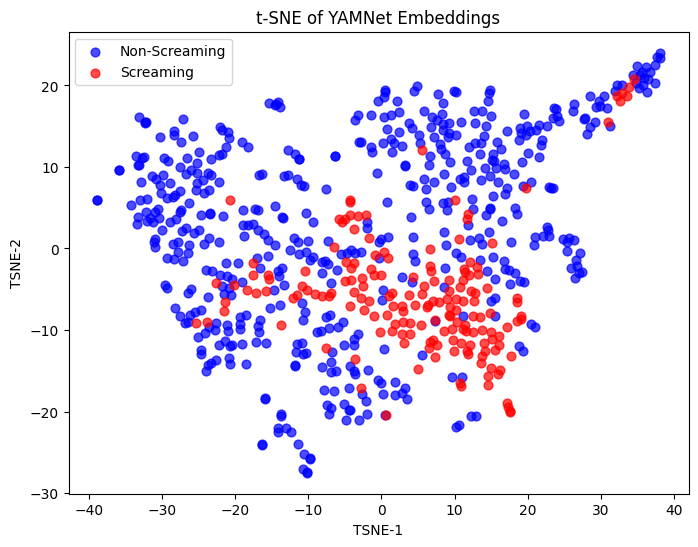

In [18]:
# Cell 17 (revised): t‑SNE of YAMNet Embeddings (matplotlib only)
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# 1) Build a matrix of all embeddings + labels
embs, labs = [], []
for fname, true in zip(test_df['filename'], test_df['label']):
    wav = load_wav_16k_mono(tf.constant(fname))
    _, e, _ = yamnet_model(wav)
    embs.append(tf.reduce_mean(e, axis=0).numpy())
    labs.append(true)

embs = np.stack(embs)
proj = TSNE(n_components=2, random_state=42).fit_transform(embs)

# 2) Plot with matplotlib
fig, ax = plt.subplots(figsize=(8,6))
colors = ['blue','red']
labels_map = {0:'Non‑Screaming', 1:'Screaming'}

for cls in [0,1]:
    idx = np.where(np.array(labs)==cls)
    ax.scatter(proj[idx,0], proj[idx,1],
               c=colors[cls],
               label=labels_map[cls],
               alpha=0.7,
               s=40)

ax.legend()
ax.set_title('t‑SNE of YAMNet Embeddings')
ax.set_xlabel('TSNE‑1')
ax.set_ylabel('TSNE‑2')
plt.show()
